# Molecular dynamics application example

## Pre-requirements

### Import dependencies

In [1]:
# Primary imports
import importlib     # Only needed for module editing
import json
import pandas as pd  # Optional dependency
from pathlib import Path
import pprint
import sys
import time
import warnings
warnings.simplefilter("ignore")  # Surpress or enable warnings

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn import datasets  # For sklearn test data set creation
from sklearn.preprocessing import StandardScaler

# CNN clustering module
import cnnclustering.cnn as cnn    # CNN clustering
import cnnclustering.cmsm as cmsm  # Core-set MSM estimation
import pydpc

This notebook was created using Python 3.8.

In [2]:
# Version information
print(sys.version)

3.8.5 | packaged by conda-forge | (default, Aug 21 2020, 18:21:27) 
[GCC 7.5.0]


### Notebook configuration

We use `matplotlib` to create plots. A `"matplotlibrc"` file can be used to customise the appearance of the plots.

In [3]:
# Matplotlib configuration
mpl.rc_file(
    "../matplotlibrc",
    use_default_template=False
)

In [4]:
# Axis property defaults for the plots
ax_props = {
    "xlabel": None,
    "ylabel": None,
    "xlim": (-2.5, 2.5),
    "ylim": (-2.5, 2.5),
    "xticks": (),
    "yticks": (),
    "aspect": "equal"
}

# Line plot property defaults
line_props = {
    "linewidth": 0,
    "marker": '.',
}

### Package configuration

In [5]:
# Configuration file found?
cnn.settings.cfgfile  # If None, no file is provided

In [6]:
# Display default settings
cnn.settings.defaults

{'default_cnn_cutoff': '1',
 'default_cnn_offset': '0',
 'default_radius_cutoff': '1',
 'default_member_cutoff': '2',
 'default_fit_policy': 'conservative',
 'default_predict_policy': 'conservative',
 'float_precision': 'sp',
 'int_precision': 'sp'}

## Helper functions

In [7]:
def draw_evaluate(clusterobject, axis_labels=False, plot="dots"):
    fig, Ax = plt.subplots(
        1, 3,
        figsize=(mpl.rcParams['figure.figsize'][0],
                 mpl.rcParams['figure.figsize'][1]*0.5)
        )

    for dim in range(3):
        dim_ = (dim * 2, dim * 2 + 1)
        
        ax_props_ = {k: v for k, v in ax_props.items()}
        if axis_labels:
            ax_props_.update({"xlabel": dim_[0] + 1, "ylabel": dim_[1] + 1})

        _ = clusterobject.evaluate(
            ax=Ax[dim], plot=plot,
            ax_props=ax_props_,
            dim=dim_
            )

## MD showcase - Langerin

Let's read in some "real world" data for this example. We will work with a 6D projection of a classical MD trajectory of the C-type lectin receptor langerin that was generated by the dimension reduction procedure TICA.

In [8]:
langerin = cnn.CNN(points=np.load("md_example/md_showcase_langerin.npy", allow_pickle=True))

After creating a `CNN` instance, we can print out basic information about the data. The projection comes in 116 parts of individual independent simulations. The number of data points in these parts is written out for the first 4 parts. In total we have about 2.6 million data points in this set representing 26 microseconds of simulation time at a sampling timestep of 10 picoseconds.

In [9]:
print(langerin)

CNN cluster object
--------------------------------------------------------------------------------
Alias :                         root
Hierachy level :                0

Data point shape :              Parts      - 116, [5571  4148  20851  99928 ...]
                                Points     - 2641593
                                Dimensions - 6

Distance matrix calculated :    None
Neighbourhoods calculated :     None
Density graph calculated :      None

Clustered :                     False
Children :                      False



Dealing with six data dimensions we can still visualise the data quite well.

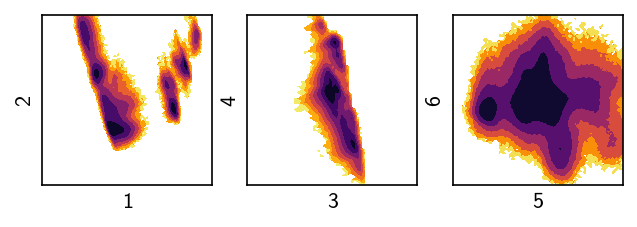

In [11]:
draw_evaluate(langerin, axis_labels=True, plot="contourf")

Clustering of this fairly large amount of data points directly is in principle possible, but it will be slow. Pre-calculating pairwise distances would occupy terabytes of disk space which we can not afford and so we have resort to brute-force on-the-fly distance calculation. To allow quick and handy data exploration and cluster result screening we want to work on a reduced data set.

In [12]:
langerin_reduced = langerin.cut(points=(None, None, 100))

Now we distance pre-calculation is feasible and clustering will be much faster. When reducing a data set it is most important that the new set remains representative of the original one. Usually using a regular stride on the data points will be appropriate.

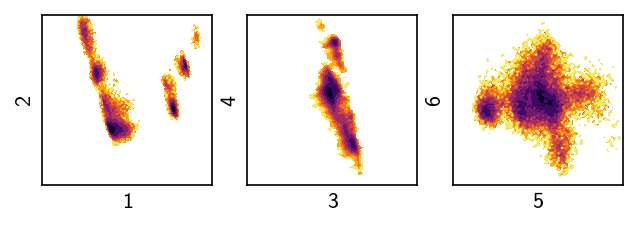

In [13]:
draw_evaluate(langerin_reduced, axis_labels=True, plot="contourf")

In [14]:
print(langerin_reduced)

CNN cluster object
--------------------------------------------------------------------------------
Alias :                         root
Hierachy level :                0

Data point shape :              Parts      - 116, [56  42  209  1000 ...]
                                Points     - 26528
                                Dimensions - 6

Distance matrix calculated :    None
Neighbourhoods calculated :     None
Density graph calculated :      None

Clustered :                     False
Children :                      False



A quick look on the distribution of distances in the set gives us a first feeling for what might be a suitable value for the neighbour search radius *r*.

Mapping: 100%|██████████| 6.00/6.00 [00:09<00:00, 1.52s/Chunks]


(<Figure size 750x450 with 1 Axes>,
 <AxesSubplot:xlabel='d / au'>,
 None)

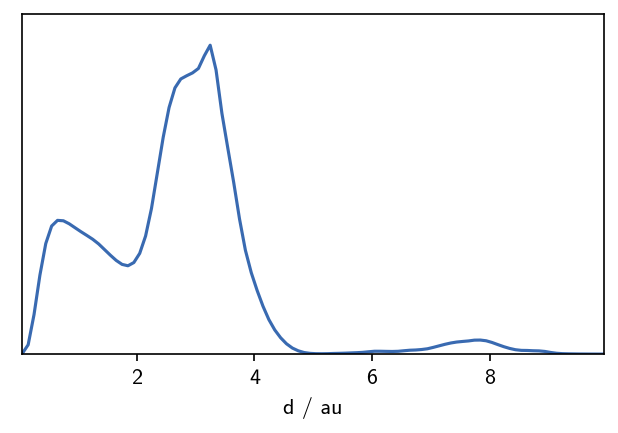

In [15]:
langerin_reduced.calc_dist(mmap=True, chunksize=5000)  # Pre-calculate point distances and temporary store on disk
langerin_reduced.dist_hist()

### Clustering root data

We can expect a split of the data into clusters for values of *r* of roughly 2 or lower. Let's attempt a first clustering step with a relatively low density criterion (large *r* cutoff, low number of common neighbours *c*):

In [16]:
langerin_reduced.fit(2, 5, policy="progressive")

Execution time for call of fit: 0 hours, 0 minutes, 23.0190 seconds
--------------------------------------------------------------------------------
#points   R         C         min       max       #clusters %largest  %noise    
26528     2.000     5         2         None      3         0.983     0.000     
--------------------------------------------------------------------------------


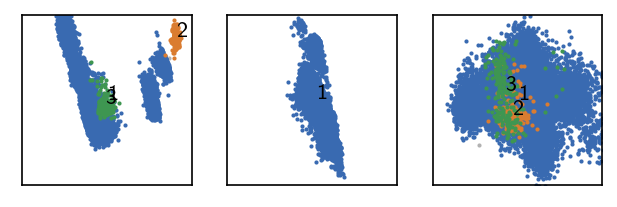

In [17]:
draw_evaluate(langerin_reduced)

### Clustering hierarchy level 1

We see that no data point was excluded as sparse outlier and we split the data into three clusters. Especially the first cluster can obviously be splitted further. Let' recluster it applying a higher density criterion. For this we first need to freeze this cluster result and isolate the obtained clusters into individual child cluster objects.

In [18]:
langerin_reduced.isolate()
current = c1 = langerin_reduced.children[1]

By default, the isolation assigns an alias to each child cluster that reveals its origin. In this case "root - 1", translates to the first child cluster of the root data.

In [20]:
current

CNN clustering object (root - 1)

In [21]:
# Recluster first cluster from last step
current.data.points.cKDTree()              # We pre-compute neighbourhoods here
r = 1
current.calc_neighbours_from_cKDTree(r=r)
current.fit(r, 5)

Execution time for call of fit: 0 hours, 0 minutes, 1.4944 seconds
--------------------------------------------------------------------------------
#points   R         C         min       max       #clusters %largest  %noise    
26079     1.000     5         2         None      3         0.727     0.000     
--------------------------------------------------------------------------------


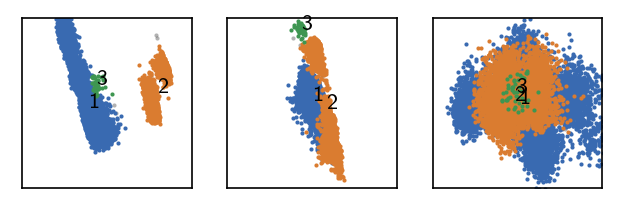

In [22]:
draw_evaluate(current)

### Clustering hierarchy level 2

The re-clustered data points are split into another three clusters. This time, we see an oportunity to again re-cluster the first two obtained clusters, slightly increasing the density criterion further.

In [23]:
current

CNN clustering object (root - 1)

In [25]:
current.isolate()
current = c1_1 = current.children[1]

In [26]:
current

CNN clustering object (root - 1 - 1)

At this stage we choose a `member_cutoff` of 10 for the fit, ensuring that we do not yiels small, meaningless clusters.

In [27]:
# Recluster first cluster from last step
current.data.points.cKDTree()  # We pre-compute neighbourhoods here
r = 0.45
current.calc_neighbours_from_cKDTree(r=r)
current.fit(r, 15, member_cutoff=10)

Execution time for call of fit: 0 hours, 0 minutes, 0.4998 seconds
--------------------------------------------------------------------------------
#points   R         C         min       max       #clusters %largest  %noise    
18947     0.450     15        10        None      3         0.946     0.027     
--------------------------------------------------------------------------------


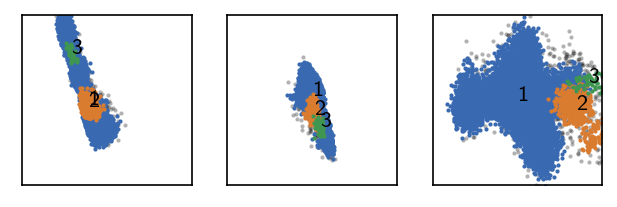

In [28]:
draw_evaluate(current)

In [29]:
current = c1_2 = c1.children[2]

In [30]:
current

CNN clustering object (root - 1 - 2)

In [31]:
# Recluster second cluster from last step
current.data.points.cKDTree()  # We pre-compute neighbourhoods here
r = 0.5
current.calc_neighbours_from_cKDTree(r=r)
current.fit(r, 10)

Execution time for call of fit: 0 hours, 0 minutes, 0.0964 seconds
--------------------------------------------------------------------------------
#points   R         C         min       max       #clusters %largest  %noise    
7077      0.500     10        2         None      3         0.613     0.010     
--------------------------------------------------------------------------------


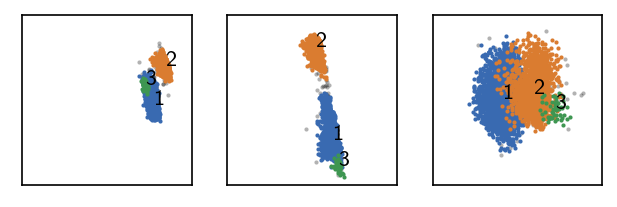

In [32]:
draw_evaluate(current)

### Clustering hierarchy level 3

And on it goes ...

In [33]:
current = c1_1

In [34]:
current.isolate()
current = c1_1_1 = current.children[1]

In [35]:
current

CNN clustering object (root - 1 - 1 - 1)

In [36]:
# Recluster first cluster from last step
current.data.points.cKDTree()  # We pre-compute neighbourhoods here
r = 0.4
current.calc_neighbours_from_cKDTree(r=r)
current.fit(r, 15)

Execution time for call of fit: 0 hours, 0 minutes, 0.3754 seconds
--------------------------------------------------------------------------------
#points   R         C         min       max       #clusters %largest  %noise    
17927     0.400     15        2         None      2         0.867     0.015     
--------------------------------------------------------------------------------


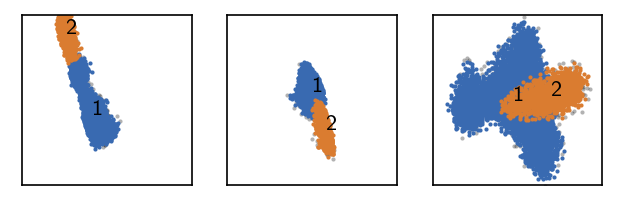

In [37]:
draw_evaluate(current)

### Clustering hierarchy level 4

In [38]:
current.isolate()
current = c1_1_1_1 = current.children[1]

In [40]:
current

CNN clustering object (root - 1 - 1 - 1 - 1)

In [39]:
# Recluster first cluster from last step
current.data.points.cKDTree()  # We pre-compute neighbourhoods here
r = 0.28
current.calc_neighbours_from_cKDTree(r=r)
current.fit(r, 15, member_cutoff=10)

Execution time for call of fit: 0 hours, 0 minutes, 0.1906 seconds
--------------------------------------------------------------------------------
#points   R         C         min       max       #clusters %largest  %noise    
15548     0.280     15        10        None      2         0.676     0.142     
--------------------------------------------------------------------------------


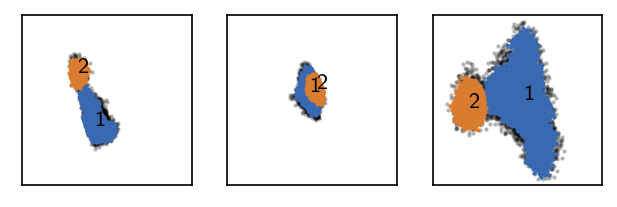

In [41]:
draw_evaluate(current)

### Clustering hierarchy level 5

In [42]:
current.isolate()
current = c1_1_1_1_1 = current.children[1]

In [43]:
current

CNN clustering object (root - 1 - 1 - 1 - 1 - 1)

In [44]:
# Recluster first cluster from last step
current.data.points.cKDTree()  # We pre-compute neighbourhoods here
r = 0.22
current.calc_neighbours_from_cKDTree(r=r)
current.fit(r, 15, member_cutoff=10)

Execution time for call of fit: 0 hours, 0 minutes, 0.1533 seconds
--------------------------------------------------------------------------------
#points   R         C         min       max       #clusters %largest  %noise    
10506     0.220     15        10        None      2         0.650     0.309     
--------------------------------------------------------------------------------


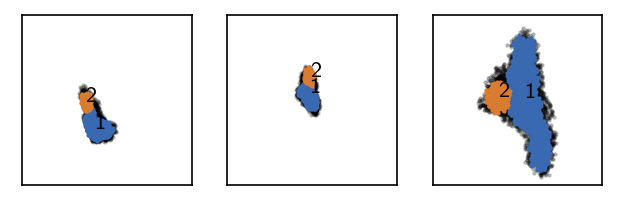

In [45]:
draw_evaluate(current)

### Merge hierarchy levels

We want to leave it with that for the moment. We can visualise our cluster hierarchy to get an overview.

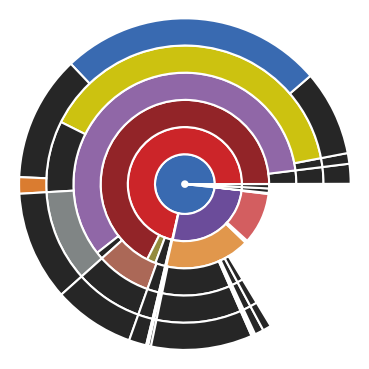

In [47]:
_ = langerin_reduced.pie()

And we can finally put everything together and incorporate the child clusters into the root data set.

In [48]:
langerin_reduced.reel(deep=None)

After this call, cluster labeling may not be contiguous and sorted by size, which we can fix easily.

In [55]:
langerin_reduced.labels.sort_by_size()

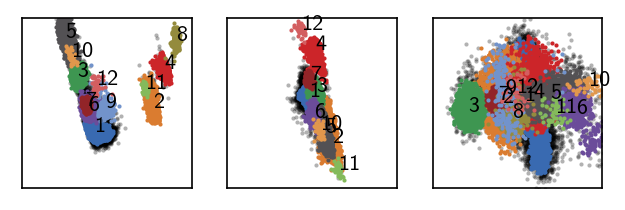

In [56]:
draw_evaluate(langerin_reduced)

In [59]:
print("Label    Size")
print("=============")
print(*sorted({k: len(v) for k, v in langerin_reduced.labels.clusterdict.items()}.items()), sep="\n")

Label    Size
(0, 6326)
(1, 6831)
(2, 4335)
(3, 2834)
(4, 2619)
(5, 2104)
(6, 451)
(7, 425)
(8, 231)
(9, 217)
(10, 55)
(11, 52)
(12, 48)


For later re-use, we save the clustering result in form of the cluster label assignments.

In [60]:
np.save("md_example/cluster_labels.npy", np.asarray(langerin_reduced.labels))

### MSM estimation

Assuming our data was sampled in a time-correlated manner as it is the case for MD simulation data, we can use this clustering result as a basis for the estimation of a core-set Markov-state model.

In [61]:
M = cmsm.CMSM(langerin_reduced.get_dtraj(), unit="ns", step=1)

In [62]:
# Estimate csMSM for different lag times (given in steps)
lags = [1, 2, 4, 8, 15, 30]
for i in lags:
    M.cmsm(lag=i, minlenfactor=5)
    M.get_its()


*********************************************************
---------------------------------------------------------
Computing coreset MSM at lagtime 1 ns
---------------------------------------------------------

Using 116 trajectories with 26380 steps over 12 coresets

All sets are connected
---------------------------------------------------------
*********************************************************


*********************************************************
---------------------------------------------------------
Computing coreset MSM at lagtime 2 ns
---------------------------------------------------------

Using 116 trajectories with 26380 steps over 12 coresets

All sets are connected
---------------------------------------------------------
*********************************************************


*********************************************************
---------------------------------------------------------
Computing coreset MSM at lagtime 4 ns
---------------------

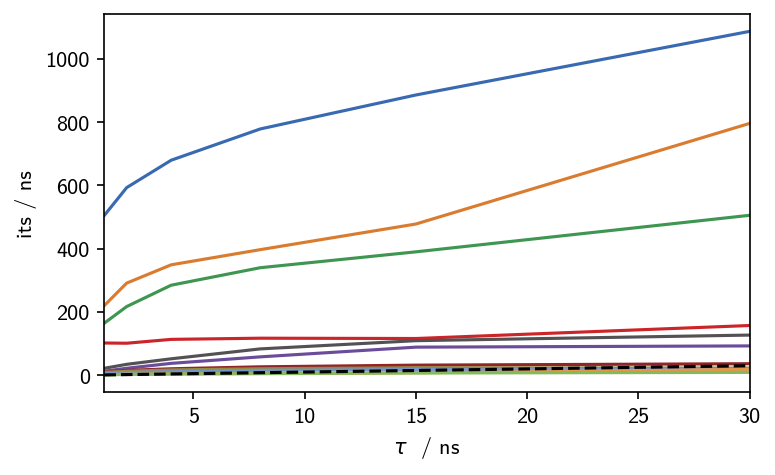

In [63]:
# Plot the time scales
fig, ax, *_ = M.plot_its()
fig.tight_layout(pad=0.1)

## Cluster alternatives

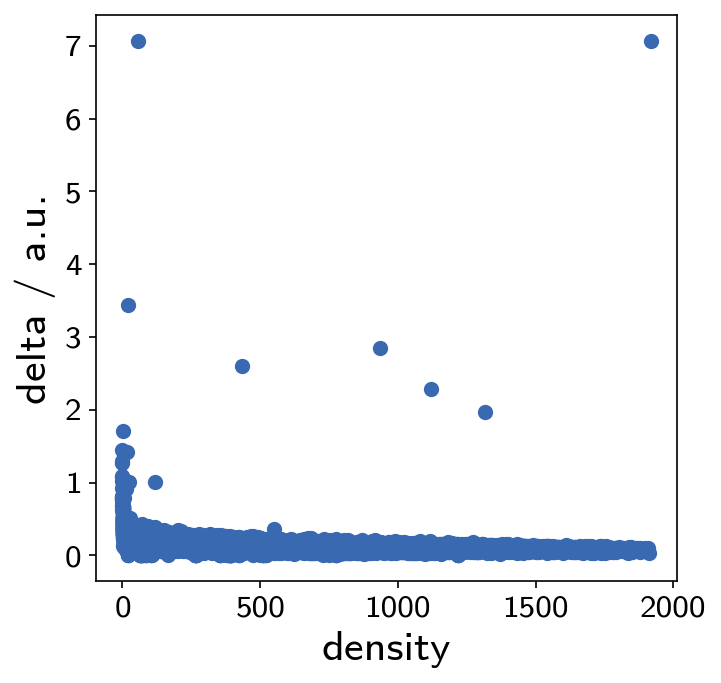

In [10]:
pydpc_clustering = pydpc.Cluster(langerin_reduced.data.points)

In [11]:
pydpc_clustering.autoplot = False

In [16]:
pydpc_clustering.assign(0, 1.8)

In [19]:
pydpc_clustering.clusters

array([  690,  5274,  5470, 11430, 14034, 16202, 17564], dtype=int32)

In [20]:
langerin_reduced.labels = (pydpc_clustering.membership + 1)

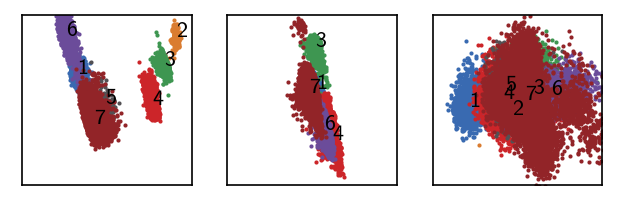

In [21]:
draw_evaluate(langerin_reduced)

In [22]:
langerin_reduced.labels[pydpc_clustering.halo_idx] = 0

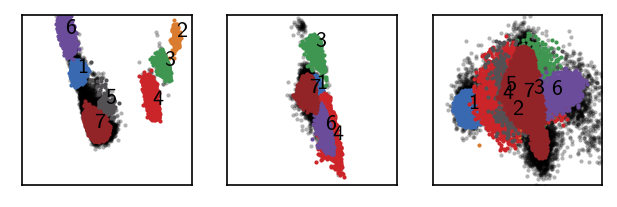

In [23]:
draw_evaluate(langerin_reduced)

In [24]:
M = cmsm.CMSM(langerin_reduced.get_dtraj(), unit="ns", step=1)

In [25]:
# Estimate csMSM for different lag times (given in steps)
lags = [1, 2, 4, 8, 15, 30]
for i in lags:
    M.cmsm(lag=i, minlenfactor=5)
    M.get_its()


*********************************************************
---------------------------------------------------------
Computing coreset MSM at lagtime 1 ns
---------------------------------------------------------

Using 116 trajectories with 25900 steps over 7 coresets

All sets are connected
---------------------------------------------------------
*********************************************************


*********************************************************
---------------------------------------------------------
Computing coreset MSM at lagtime 2 ns
---------------------------------------------------------

Using 116 trajectories with 25900 steps over 7 coresets

All sets are connected
---------------------------------------------------------
*********************************************************


*********************************************************
---------------------------------------------------------
Computing coreset MSM at lagtime 4 ns
-----------------------

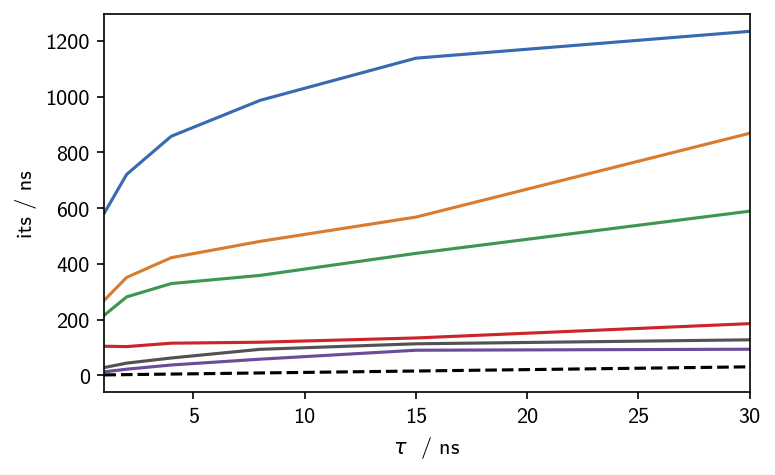

In [26]:
# Plot the time scales
fig, ax, *_ = M.plot_its()
fig.tight_layout(pad=0.1)

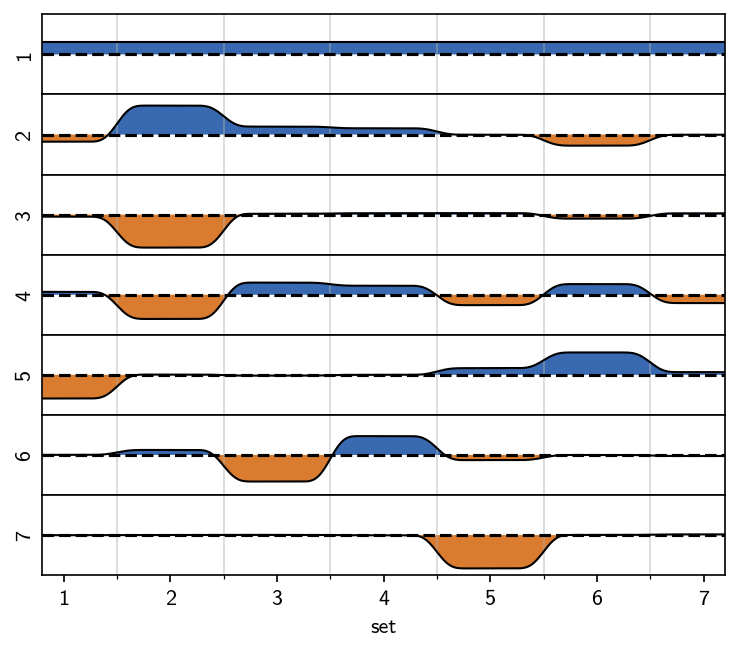

In [36]:
figsize = mpl.rcParams["figure.figsize"]
mpl.rcParams["figure.figsize"] = figsize[0], figsize[1] * 0.2
M.plot_eigenvectors()
mpl.rcParams["figure.figsize"] = figsize